# CAB420 Assignment 1B Question 1: Template and Utilities Demo

## Overview

This notebook provides a quick demo and overview of the provided utility functions to help with Assignment 1B, Question 1.

Please make sure you read the assignment brief on canvas, and check the FAQ for other information.

**Note: File paths used in this template may need to change for your local machine. Please set these based on your local file system structure.**

## Utility Functions

The following cell contains utility functions to:
* Load the data
* Split the training set into training and validation sets
* Extract gallery and probe arrays from the validation set
* Vectorise the data
* Plot images
* Resize all images
* Convert images to grayscale
* Build pairs or triplets of images for metric learning networks
* Plot a CMC Curve

These are provided to assist you in developing your solution.

In [1]:
#
# Utility functions for CAB420, Assignment 1B, Q1
# Author: Simon Denman (s.denman@qut.edu.au)
#
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt     # for plotting
import numpy as np                  # for reshaping, array manipulation
import cv2                          # for image loading and colour conversion
import tensorflow as tf             # for bulk image resize
import glob
import random
import keras

# get the subject ID from the filename. A sample filename is 0001_c1s1_001051_00.jpg, the first
# four characters are the subject ID
#   fn:      the filename to parse
# 
#   returns: first four characters of the filename converted to an int
#
def get_subject_id_from_filename(fn):
    return int(fn[0:4])

# load the images in a directory
#   base_path: path to the data
#
#   returns:   numpy arrays of size (samples, width, height, channels), and size (samples) for 
#              images and thier labels
def load_directory(base_path):

    # find all images in the directory
    files = glob.glob(os.path.join(base_path, '*.jpg'))
    x = []
    y = []
    
    # loop through the images, loading them and extracting the subject ID
    for f in files:
        x.append(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) / 255.0)
        y.append(get_subject_id_from_filename(os.path.basename(f)))
        
    return np.array(x), np.array(y)

# Split the training set into train and validation, with a disjoint set of IDs in each
#   X:         X data to split
#   Y:         Y data to split, corresponds to X
#   id_cutoff: Any IDs equal or smaller than this will be train, the rest will be in validation
#
#   returns:   numpy arrays for the training and validation sets, which contain mutually exclusise sets
#              of subjects
#
def split_validation(X, Y, id_cutoff = 250):

    train_X = X[Y <= id_cutoff, :]
    train_Y = Y[Y <= id_cutoff]

    val_X = X[Y > id_cutoff, :]
    val_Y = Y[Y > id_cutoff]

    return train_X, train_Y, val_X, val_Y

# Extract gallery and probe sets from a given chunk of data. Gallery and probe will contain one sample each
# for each subject, with only the first and second images for each subject used, and the rest discarded.
#   X:         X data to split
#   Y:         Y data to split, corresponds to X
#
#   returns:   numpy arrays containing gallery and probe sets corresponding to the input data. Gallery and
#              probe will both contain one image of each subject. Any subjects with fewer than two images 
#              will be discarded
#
def sample_gallery_and_probe(X, Y):
    
    # storage
    gallery_X = []
    gallery_Y = []
    probe_X = []
    probe_Y = []

    # find unique IDs
    unique_ids = np.unique(Y)
    # loop through unique IDs
    for i in unique_ids:
        # pull out samples for the current ID
        samples = X[Y == i, :]
        # need at least two samples for use the ID
        if samples.shape[0] >= 2:
            # first sample for a subject stored in the gallery
            gallery_X.append(samples[0, :])
            gallery_Y.append(i)
            # second sample stored in the probe
            probe_X.append(samples[1, :])
            probe_Y.append(i)
            # any other images for the subject are ignored

    # return extracted data
    return np.array(gallery_X), np.array(gallery_Y), np.array(probe_X), np.array(probe_Y)

# load the data
#   base_path: path to the data, within the directory that this points to there should be a 'Training' 
#              and 'Testing' directory
#
#   returns:   loaded data
#
def load_data(base_path):
    
    # load training data
    train_X, train_Y = load_directory(os.path.join(base_path, 'Training'))
    # split validation data
    train_X, train_Y, val_X, val_Y = split_validation(train_X, train_Y)

    # load gallery data from the test set
    gallery_X, gallery_Y = load_directory(os.path.join(base_path, 'Testing', 'Gallery'))

    # load probe data from the test set
    probe_X, probe_Y = load_directory(os.path.join(base_path, 'Testing', 'Probe'))
    
    return train_X, train_Y, val_X, val_Y, gallery_X, gallery_Y, probe_X, probe_Y

# Plot some images and their labels. Will plot the first 50 samples in a 10x5 grid
#  x: array of images, of shape (samples, width, height, channels)
#  y: labels of the images
#
def plot_images(x, y):
    fig = plt.figure(figsize=[15, 18])
    for i in range(50):
        ax = fig.add_subplot(5, 10, i + 1)
        ax.imshow(x[i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title(y[i])
        ax.axis('off')
        
# vectorise an array of images, such that the shape is changed from {samples, width, height, channels} to
# (samples, width * height * channels)
#   images: array of images to vectorise
#
#   returns: vectorised array of images
#
def vectorise(images):
    # use numpy's reshape to vectorise the data
    return np.reshape(images, [len(images), -1])

# Resize an array of images
#  images:   array of images, of shape (samples, width, height, channels)
#  new_size: tuple of the new size, (new_width, new_height)
#
#  returns:  resized array of images, (samples, new_width, new_height, channels)
#
def resize(images, new_size):
    # tensorflow has an image resize funtion that can do this in bulk
    # note the conversion back to numpy after the resize
    return tf.image.resize(images, new_size).numpy()
          
# Convert images to grayscale
#   images:  array of colour images to convert, of size (samples, width, height, 3)
#
#   returns: array of converted images, of size (samples, width, height, 1)
#
def convert_to_grayscale(images):
    # storage for converted images
    gray = []
    # loop through images
    for i in range(len(images)):
        # convert each image using openCV
        gray.append(cv2.cvtColor(images[i,:], cv2.COLOR_RGB2GRAY))
    # pack converted list as an array and return
    return np.expand_dims(np.array(gray), axis = -1)

# Create a batch of siamese data. Pairs will be evenly balanced, such that there is an
# equal number of positive and negative pairs
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of pairs to generate 
#
#   returns:    image pairs and labels to indicate if the pairs are the same, or different
#
def get_siamese_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    label = np.zeros(batch_size);
    
    for i in range(batch_size):
        
        if (i % 2 == 0):
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 1
            while (labels[idx1] != labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)            
                
        else:
            idx1 = random.randint(0, len(imgs) - 1)
            idx2 = random.randint(0, len(imgs) - 1)
            l = 0
            while (labels[idx1] == labels[idx2]):
                idx2 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        label[i] = l

    return [image_a, image_b], label
        
# Plot the first 10 pairs of a batch, good sanity check for pair generation
#  x: images in the pairs
#  y: labels of the pairs
#
def plot_pairs(x, y):
    fig = plt.figure(figsize=[25, 6])
    for i in range(10):
        ax = fig.add_subplot(2, 10, i*2 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))

        ax = fig.add_subplot(2, 10, i*2 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Pair ' + str(i) +'; Label: ' + str(y[i]))
        
# Create a batch of triplet data.
#   imgs:       images to use to generate data, of shape (samples, width, height, channels)
#   labels:     labels for the data, of shape (samples)
#   batch_size: number of triplets to generate 
#
#   returns:    triplet of the requested batch size
#
def get_triplet_data(imgs, labels, batch_size):

    image_a = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_b = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    image_c = np.zeros((batch_size, np.shape(imgs)[1], np.shape(imgs)[2], np.shape(imgs)[3]));
    
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c]

# Plot the first 9 triplets of a batch, good sanity check for triplet generation
#  x: images in the triplets
#
def plot_triplets(x):
    fig = plt.figure(figsize=[25, 10])
    for i in range(9):
        ax = fig.add_subplot(3, 9, i*3 + 1)
        ax.imshow(x[0][i,:], cmap=plt.get_cmap('Greys'))
        ax.set_title('Triple ' + str(i) + ': Anchor')

        ax = fig.add_subplot(3, 9, i*3 + 2)
        ax.imshow(x[1][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Positive')

        ax = fig.add_subplot(3, 9, i*3 + 3)
        ax.imshow(x[2][i,:], cmap=plt.get_cmap('Greys'))    
        ax.set_title('Triple ' + str(i) + ': Negative')

        
# Compute a ranked histogram, which can be used to generate a CMC curve. This function will loop 
# through all probe samples. For each probe sample it will:
#  - Compare the sample to all gallery samples to get a distance between the probe sample and 
#    all gallery samples. In this case it is the L2 distance
#  - Sort the gallery samples by how close they are to the probe samples
#  - Find the location of the true match
#  - Update a ranked histogram based on this
# The ranked histogram will show how many samples are matched at each rank. For example,
# ranked_histogram[0] will record how many samples are matched at Rank-1. 
#
# This implementation assumes that there is only one sample per ID in the gallery set
#
# NOTE: L2 distance, used here, may not be appropriate for all problems. Consider the nature
# of your problem and what distance measure you should use
#
#   gallery_feat: features for the gallery data, of shape (gallery_samples, num_features)
#   gallery_Y:    IDs of the gallery samples, of shape (gallery_samples,)
#   probe_feat:   features for the probe data, of shape (probe_samples, num_features)
#   probe_Y:      IDs of the probe samples, of shape (probe_samples,)
#   verbose:      bool to indicate if debug information shoudl be printed. Be careful using this with 
#                 large feature sets, and/or lots of samples
#   
#   returns:      ranked histogram matching the probe samples to the gallery
#
def get_ranked_histogram_l2_distance(gallery_feat, gallery_Y, probe_feat, probe_Y, verbose = False):
    
    # storage for ranked histogram
    # length equal to number of unique subjects in the gallery
    ranked_histogram = np.zeros(len(np.unique(gallery_Y)))

    # loop over all samples in the probe set
    for i in range(len(probe_Y)):
        # get the true ID of this sample
        true_ID = probe_Y[i]
        if verbose:
            print('Searching for ID %d' % (true_ID))

        # get the distance between the current probe and the whole gallery, L2 distance here. Note that L2
        # may not always be the best choice, so consider your distance metric given your problem
        dist = np.linalg.norm(gallery_feat - probe_feat[i,:], axis=1, ord=2)
        if verbose:
            print(dist)

        # get the sorted order of the distances
        a = np.argsort(dist)
        # apply the order to the gallery IDs, such that the first ID in the list is the closest, the second
        # ID is the second closest, and so on
        ranked = gallery_Y[a]
        if verbose:
            print('Ranked IDs for query:')
            print(a)

        # find the location of the True Match in the ranked list
        ranked_result = np.where(ranked == true_ID)[0][0]
        if verbose:
            print(ranked_result)

        # store the ranking result in the histogram
        ranked_histogram[ranked_result] += 1
        if verbose:
            print('')
    
    if verbose:
        print(ranked_histogram)
    
    return ranked_histogram

# Convert a ranked histogram to a CMC. This simply involves computing the cumulative sum over the histogram
# and dividing it by the length of the histogram
#   ranked_hist: ranked histogram to convert to a CMC
#
#   returns:     CMC curve
#
def ranked_hist_to_CMC(ranked_hist):

    cmc = np.zeros(len(ranked_hist))
    for i in range(len(ranked_hist)):
        cmc[i] = np.sum(ranked_hist[:(i + 1)])
    
    return (cmc / len(ranked_hist))

# plot a CMC
#   cmc: cmc data to plot
#
def plot_cmc(cmc):
    fig = plt.figure(figsize=[10, 8])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(1, len(cmc)+1), cmc)
    ax.set_xlabel('Rank')
    ax.set_ylabel('Count')
    ax.set_ylim([0, 1.0])
    ax.set_title('CMC Curve')      

E0000 00:00:1746758308.365456      94 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746758308.369894      94 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Utility Function Demonstration

The following presents a brief demonstration of the utility functions. These portions of code do not form part of the template, or solution, and could be commented out/removed, or you could restructure this portion of the code to form part of your solution.

### Data Loading

This will load the data, pulling out the training set and validation set, and gallery and probe testing sets. Note that to ready the validation set for the target identification function, you still need to call the `sample_gallery_and_probe` function (see below for details).

Note the size of the datasets here, and the number of unique subjects in each:
* The training set contains images for 250 unique IDs, with multiple images for each.
* The validation set contains a different 50 identities, with multiple images for each.
* The testing set is the gallery and probe sets combined:
  * The gallery set contains 1 image for another 301 unique IDs (totally separate to those in the training and validation sets) 
  * The probe set contains another single image for the same 301 subjets as the gallery set.

(4711, 128, 64, 3)
(4711,)
(1222, 128, 64, 3)
(1222,)
(301, 128, 64, 3)
(301,)
(301, 128, 64, 3)
(301,)


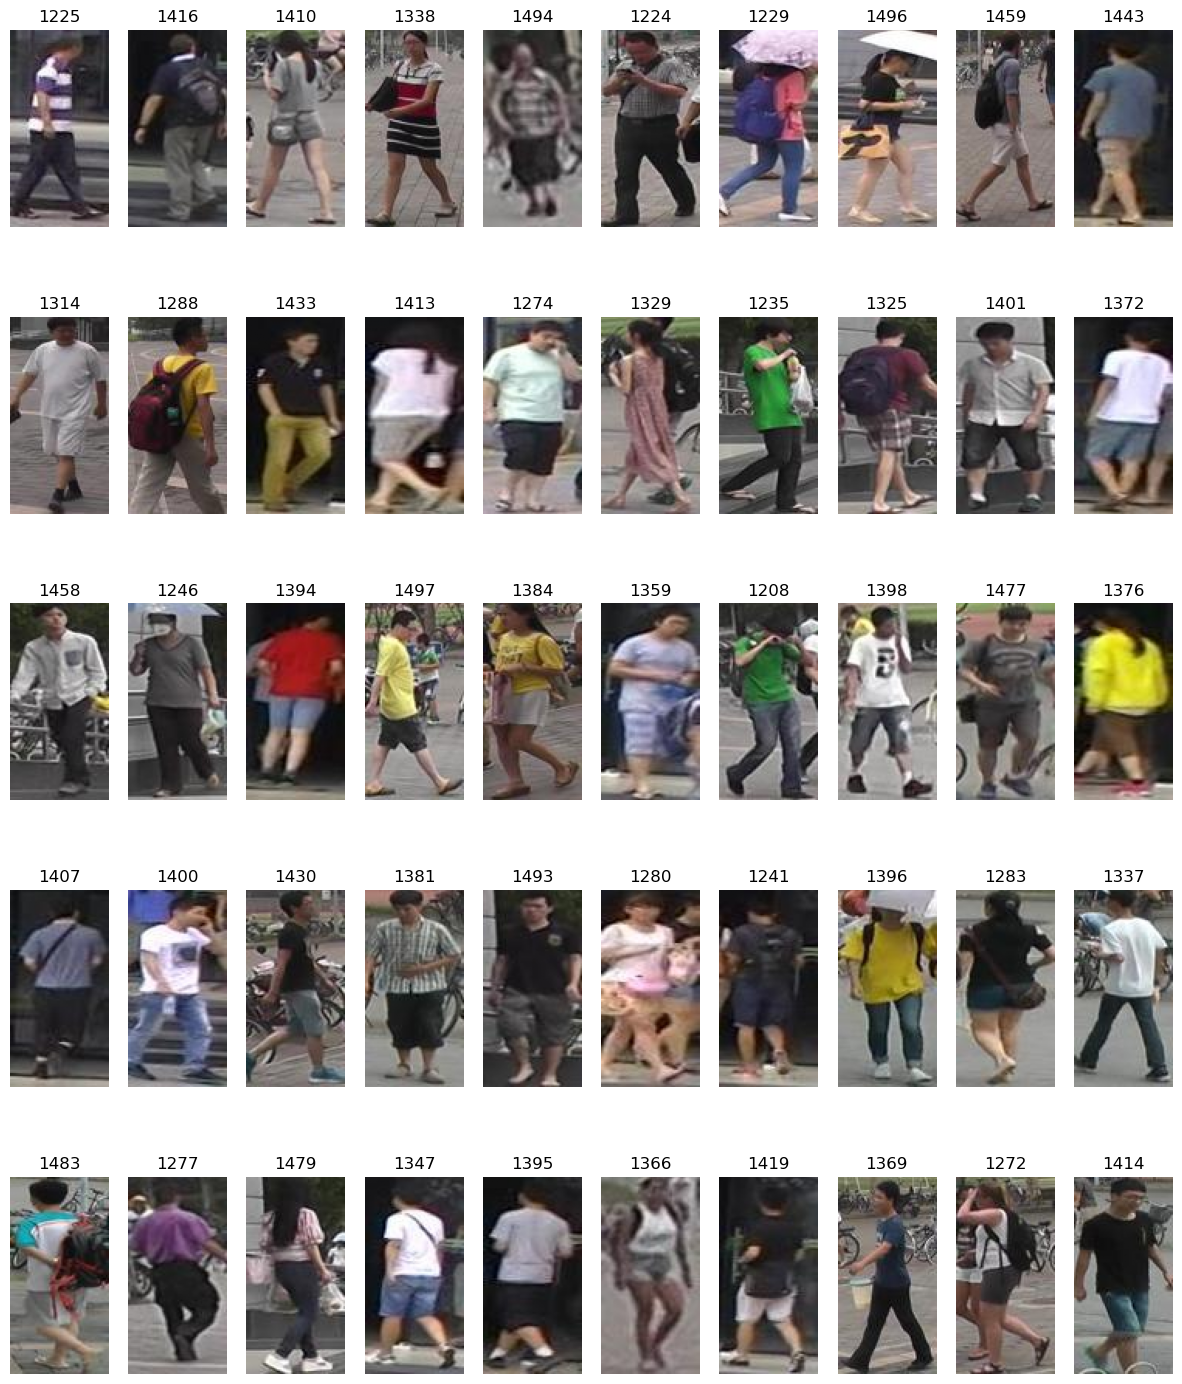

In [2]:
# note that you will probably need to change the filepath here
train_X, train_Y, val_X, val_Y, gallery_X, gallery_Y, probe_X, probe_Y = load_data('Q1/')
print(train_X.shape)
print(train_Y.shape)
print(val_X.shape)
print(val_Y.shape)
print(gallery_X.shape)
print(gallery_Y.shape)
print(probe_X.shape)
print(probe_Y.shape)

# plot some images
plot_images(gallery_X, gallery_Y)

### Validation Gallery and Probe Sets

If you wish to use the validation set to simulate the test set and compute rank accuracies (or similar) to help select hyper-parameters, you will need to extract gallery and probe samples from the set. We can do this using the following.

Note that this will give us 50 samples in both sets, as we have 50 unique IDs and we're getting one sample per ID.

In [3]:
val_gallery_X, val_gallery_Y, val_probe_X, val_probe_Y = sample_gallery_and_probe(val_X, val_Y)

print(val_gallery_X.shape)
print(val_gallery_Y.shape)
print(val_probe_X.shape)
print(val_probe_Y.shape)

(50, 128, 64, 3)
(50,)
(50, 128, 64, 3)
(50,)


### Pair and Triplet Data

Pair and triplet functions are provided to pull out paired and triplet data for use with Siamese networks. If you want pairs or triplets for the validation set, you would use the `val_X` and `val_Y` variables loaded by `load_data`

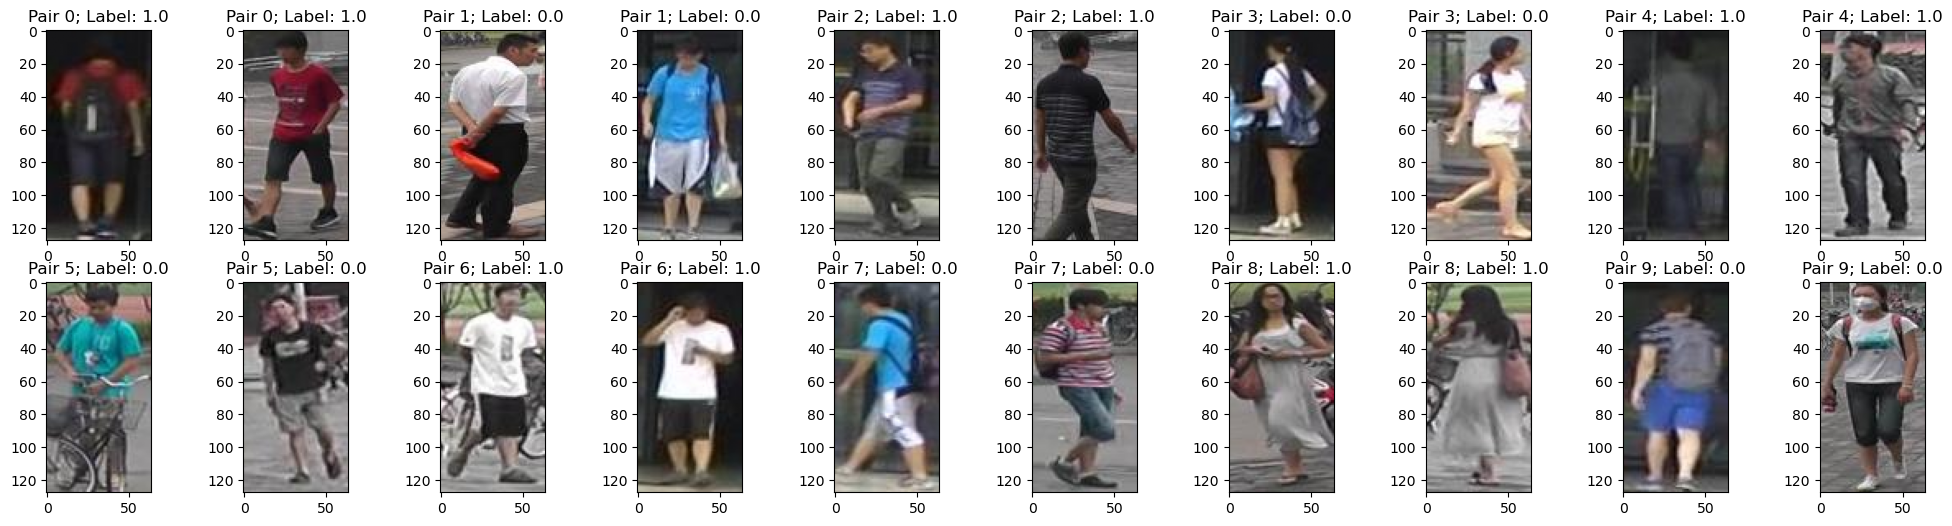

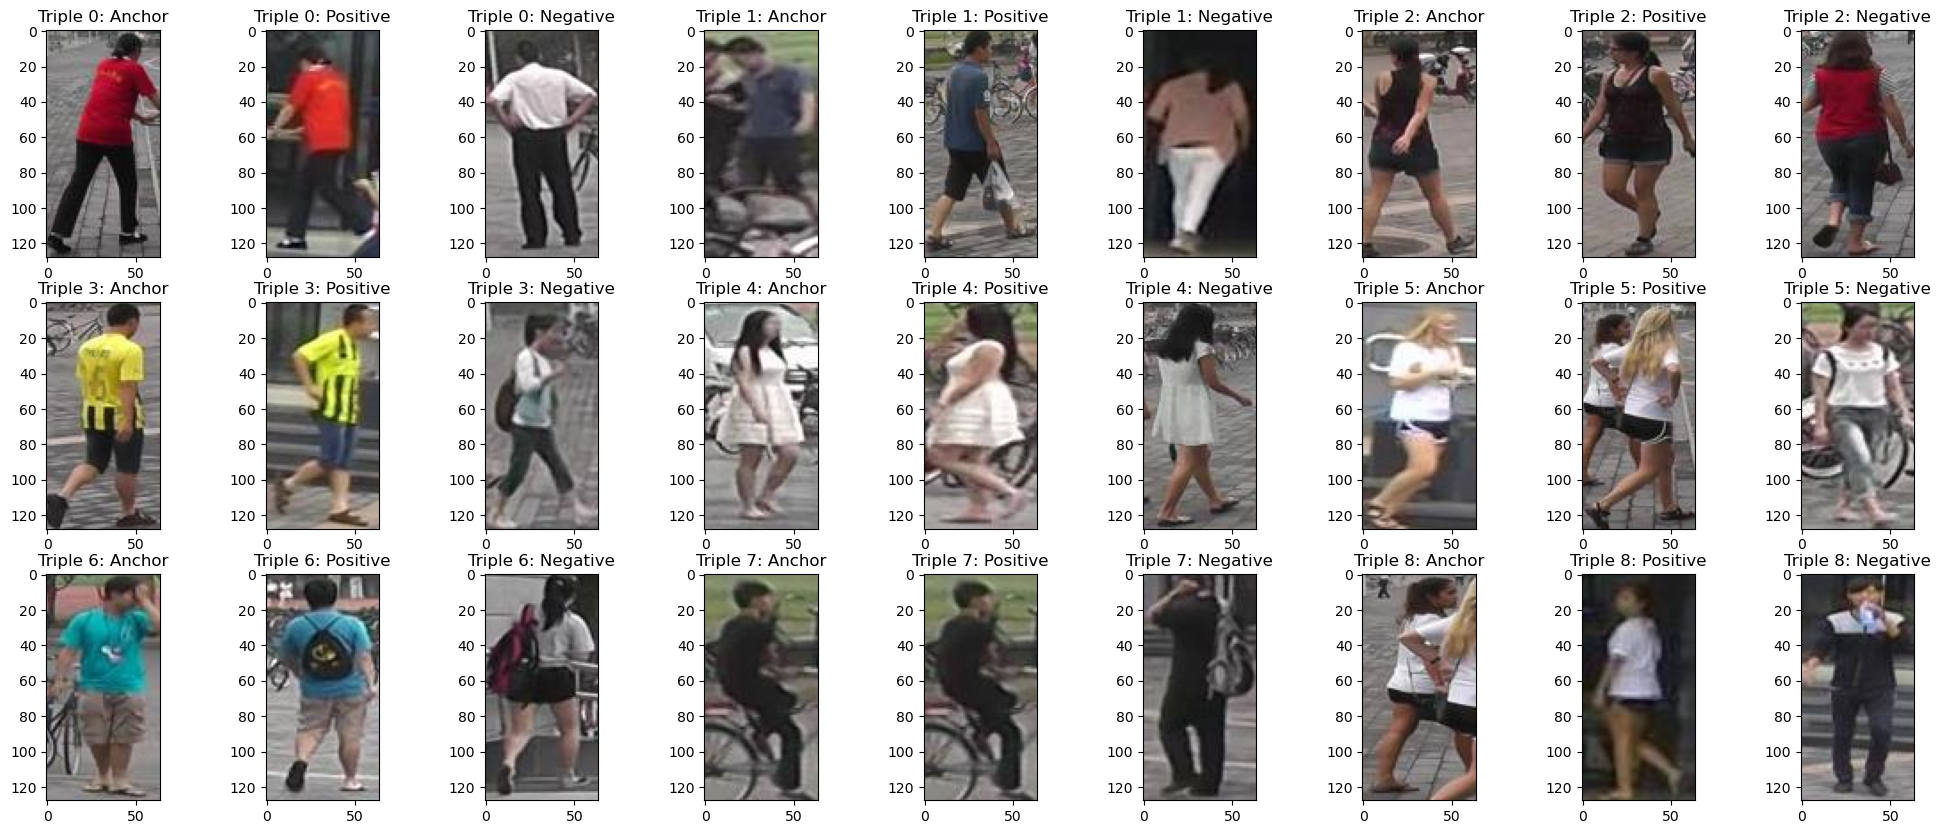

In [4]:
# create a pair generator and display a pair
x, y = get_siamese_data(train_X, train_Y, 10)
plot_pairs(x, y)

# create a triplet and display a triplet
x = get_triplet_data(train_X, train_Y, 9)
plot_triplets(x)

### Conversion and Resizing

Functions to convert images to greyscale and resize them are also provided.

I0000 00:00:1746758357.596544      94 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1880 MB memory:  -> device: 0, name: NVIDIA A16-4Q, pci bus id: 0000:02:01.0, compute capability: 8.6


(301, 64, 32, 1)
(301, 64, 32, 1)


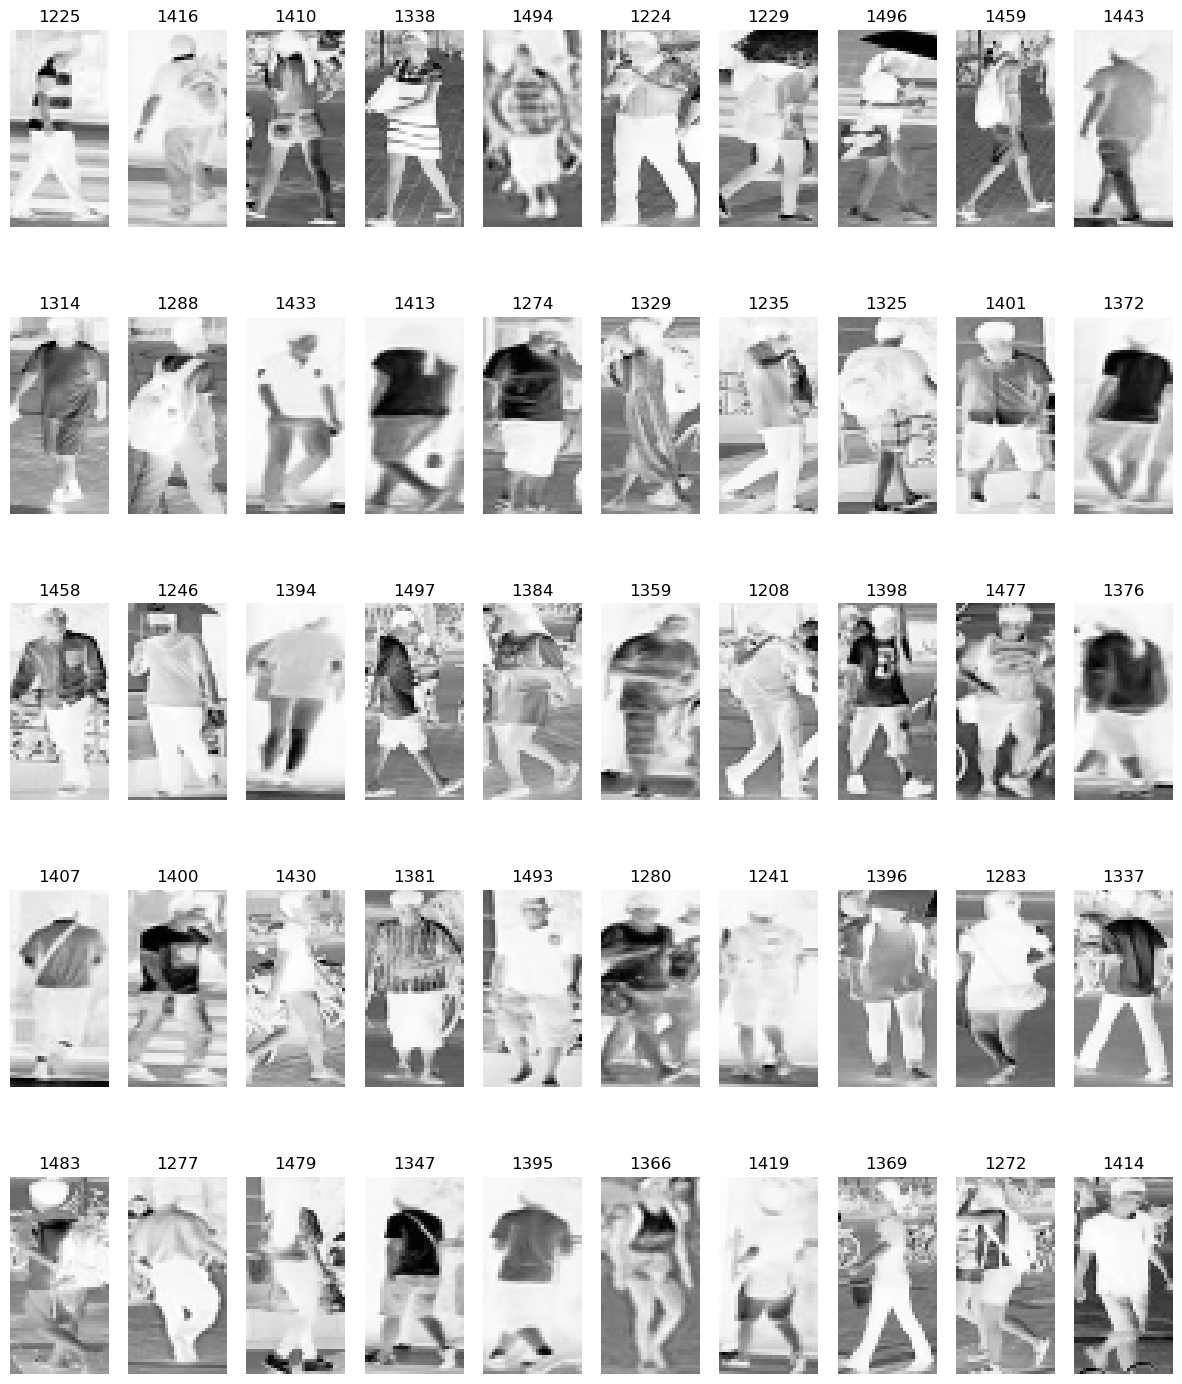

In [5]:
# resize data and convert to grayscale
gallery_X_small_gray = convert_to_grayscale(resize(gallery_X, (64, 32)))
print(gallery_X_small_gray.shape)
probe_X_small_gray = convert_to_grayscale(resize(probe_X, (64, 32)))
print(probe_X_small_gray.shape)

# plot some resized and grayscale images
plot_images(gallery_X_small_gray, gallery_Y)

### Vectorising Data

To use the images with non-DL methods, they need to be vectorised. A function is provided for this.

In [6]:
# vectorise some data
gallery_feat_vec = vectorise(gallery_X_small_gray)
probe_feat_vec = vectorise(probe_X_small_gray)
print(gallery_feat_vec.shape)
print(probe_feat_vec.shape)

#
# at this point, you have data in the shape (gallery_samples, number_of_features) and (probe_samples, number_of_features)
#

(301, 2048)
(301, 2048)


### CMC Curves

Functions to create a CMC curve are provided. These assume that you have data in the following form:
* An array of gallery features, of size (gallery_samples, num_features)
* An array of gallery IDs, of size (gallery_samples)
* An array of probe features, of size (probe_samples, num_features)
* An array of probe IDs, of size (probe_samples)

Note that the provided implementation is limited in that it assumes that you have only one sample from each gallery ID in the set of gallery samples.

The process of generating a CMC is split across three functions:
* ``get_ranked_histogram_l2_distance``, which will compare each probe sample to all gallery samples and determine the location of the correct match (the rank), storing this in a histogram
* ``ranked_hist_to_CMC``, which will convert the ranked histogram to a CMC
* ``plot_cmc``, which will actually plot the CMC

Two simple examples demonstrating this are given below.

[0 1 2 3 4 5 6 7]
[[-1.09420465 -0.20162914]
 [-0.72044461  1.96021595]
 [ 2.12485907  0.02724256]
 [ 3.37445744  1.18384723]
 [ 4.63557849  4.8478129 ]
 [ 5.41667181  3.39656562]
 [ 5.53921953  7.07104252]
 [ 6.56353809  8.91401509]]
(8, 2)
[0 1 2 3 4 5 6 7]
[[ 0.45761113  0.65663464]
 [-0.20643413  1.68294962]
 [ 4.07022775 -0.76765669]
 [ 2.2835089  -0.57608413]
 [ 0.21014565  2.85762688]
 [ 7.32940989  2.05117903]
 [ 9.37396786  6.97550548]
 [ 3.08244009  9.59626957]]
(8, 2)
Searching for ID 0
[ 1.773344    1.75702577  1.78209149  2.96410957  5.91788699  5.66564247
  8.18335948 10.26969697]
Ranked IDs for query:
[1 0 2 3 5 4 6 7]
1

Searching for ID 1
[2.08321233 0.58402345 2.85942195 3.61550656 5.78458692 5.87841818
 7.87680653 9.90559598]
Ranked IDs for query:
[1 0 2 3 4 5 6 7]
0

Searching for ID 2
[5.19535843 5.51287864 2.10150521 2.07182622 5.64385685 4.37648935
 7.97515782 9.99756794]
Ranked IDs for query:
[3 2 5 0 1 4 6 7]
1

Searching for ID 3
[ 3.3984063   3.93148252  0.62

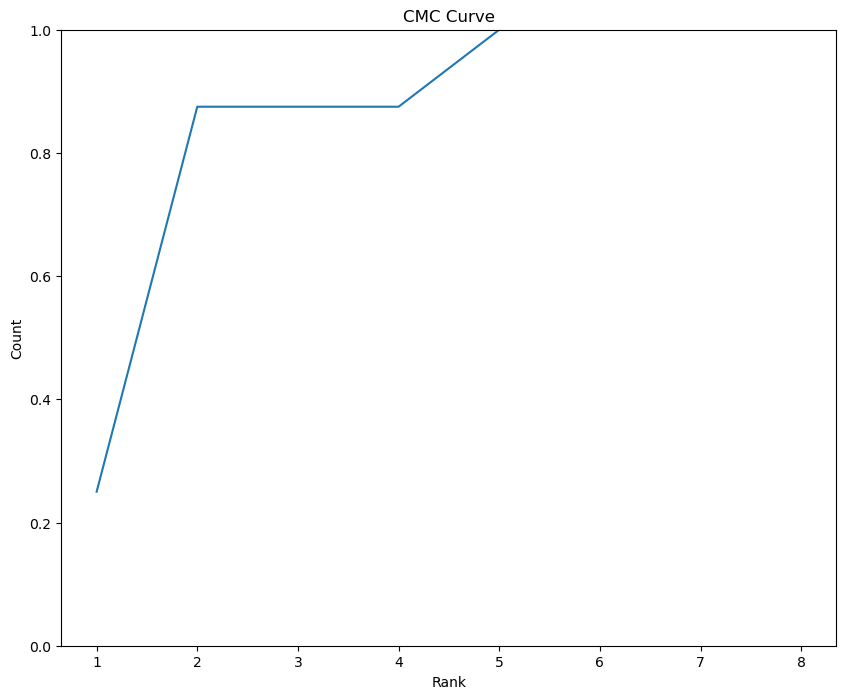

In [7]:
# we'll start off with just 8 IDs
num_ids = 8

# we'll create a list of IDs, these are the gallery and probe IDs (gallery_y and probe_y)
ID_1 = np.arange(0, num_ids, 1)
ID_2 = np.arange(0, num_ids, 1)
# we'll then generate some features
# to keep this simple, we'll use a 2D feature, i.e. each sample will have a 2D feature associated with it
# this means that we have our gallery features of size (8, 2), as we have 8 samples and 2D feaures
Feat_1 = np.transpose(np.vstack([ID_1, ID_1]) + (np.random.rand(2, num_ids) - 0.5)*4.0, (1,0))
Feat_2 = np.transpose(np.vstack([ID_2, ID_2]) + (np.random.rand(2, num_ids) - 0.5)*8.0, (1,0))

# print features and their shape to confirm what we have
print(ID_1)
print(Feat_1)
print(Feat_1.shape)
print(ID_2)
print(Feat_2)
print(Feat_2.shape)

# we can now compute the ranked histogram
# this will print out of a heap of debug data to show what's going on. In particular we see the distance between
# each probe sample and the whole gallery, and the rank of the true match, which is what is used to build the 
# ranked histogram
ranked_hist = get_ranked_histogram_l2_distance(Feat_1, ID_1, Feat_2, ID_2, True)
print(ranked_hist)
cmc = ranked_hist_to_CMC(ranked_hist)
print(cmc)
plot_cmc(cmc)

The above example results in a pretty simple CMC. Let's throw more IDs at it to get something that looks a bit better. The setup here is the same as what's above, we just have 100 gallery and probe samples now instead.

(100, 2)
(100, 2)


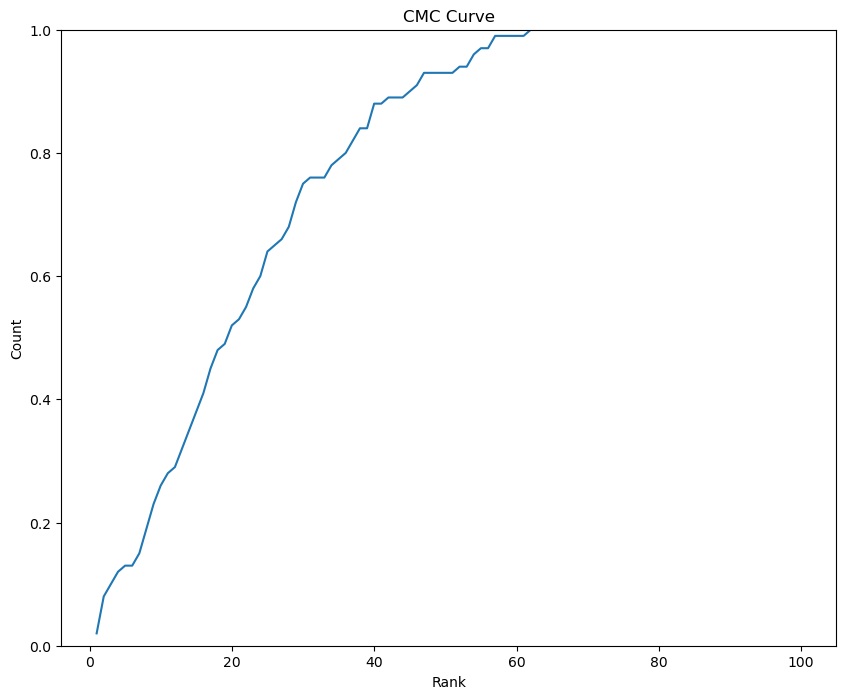

In [8]:
num_ids = 100

ID_1 = np.arange(0, num_ids, 1)
ID_2 = np.arange(0, num_ids, 1)
Feat_1 = np.transpose(np.vstack([ID_1, ID_1]) + (np.random.rand(2, num_ids) - 0.5)*20.0, (1,0))
Feat_2 = np.transpose(np.vstack([ID_2, ID_2]) + (np.random.rand(2, num_ids) - 0.5)*80.0, (1,0))
print(Feat_1.shape)
print(Feat_2.shape)

ranked_hist = get_ranked_histogram_l2_distance(Feat_1, ID_1, Feat_2, ID_2)
cmc = ranked_hist_to_CMC(ranked_hist)
plot_cmc(cmc)

With a CMC, the ideal curve is one that is always at 100%. The steeper the curve and faster it get's to 100%, the better.

## Question 1 Template

The following provides a starting point for your solution, and some suggestions on how to proceed.

### Task Overview

In [9]:
# This question concerns person re-identification. We can think of this as a retrieval problem, where the input is an image
# and the output is a list of people, ranked based on how similar they are to the image. To get this similarity-based
# ranking, we need a way to compare two images and measure their similarity. To do this you will use a learned representation.
# The question asks you to train two models (one non-DL, one DL) to extract such a representation of an image. Using this
# learned representation, you can then transform a pair of images into vectors, and the distance between the vectors is a 
# measure of their similarity.
#
# The data you have been given is split into as follows: 
#  * training: Within the training set, you have roughly 2-20 images of 250 different people. You will use this data to train
#              your model. 
#  * validation: With the validation set, you have roughly 2-20 images of 50 different people. The 50 people here are totally
#                different from those in the training set. You will use this data is you want a validation set to train a 
#                deep net, or if you want a validation probe and gallery set to tune model hyper-parameters such as embedding
#                size or number of components to keep (note that what hyper-parameters you care about will depend on what
#                models you are using.
#  * testing: This itself is split into gallery and probe. The gallery and probe each contain one image for 301 individuals. 
#             The gallery and probe both contain the same 301 individuals. This is your test set. Note that the 301 individuals
#             here are again totally different from those in the training and validation sets. When thinking about this set, 
#             consider the re-ID problem. The gallery set contains images of 301 people that have been seen on some CCTV network. 
#             The probe set represents images that you are trying to match to those in the gallery set.
#

### Data loading and Pre-processing

In [10]:
# Load the data
# Change the path to whatever is appropriate on your system
train_X, train_Y, val_X, val_Y, gallery_X, gallery_Y, probe_X, probe_Y = load_data('Q1/')

# Pre-processing
# Do any resizing, colour conversion, etc, here. You can use the resize and convert_to_grayscale functions defined above. If
# you're keen, you could also look at other colour spaces - however this is not needed
#
# Note that you will do the same pre-processing to all datasets
# Resize and convert to grayscale for all datasets
train_X = convert_to_grayscale(resize(train_X, (64, 32)))
val_X = convert_to_grayscale(resize(val_X, (64, 32)))
gallery_X = convert_to_grayscale(resize(gallery_X, (64, 32)))
probe_X = convert_to_grayscale(resize(probe_X, (64, 32)))

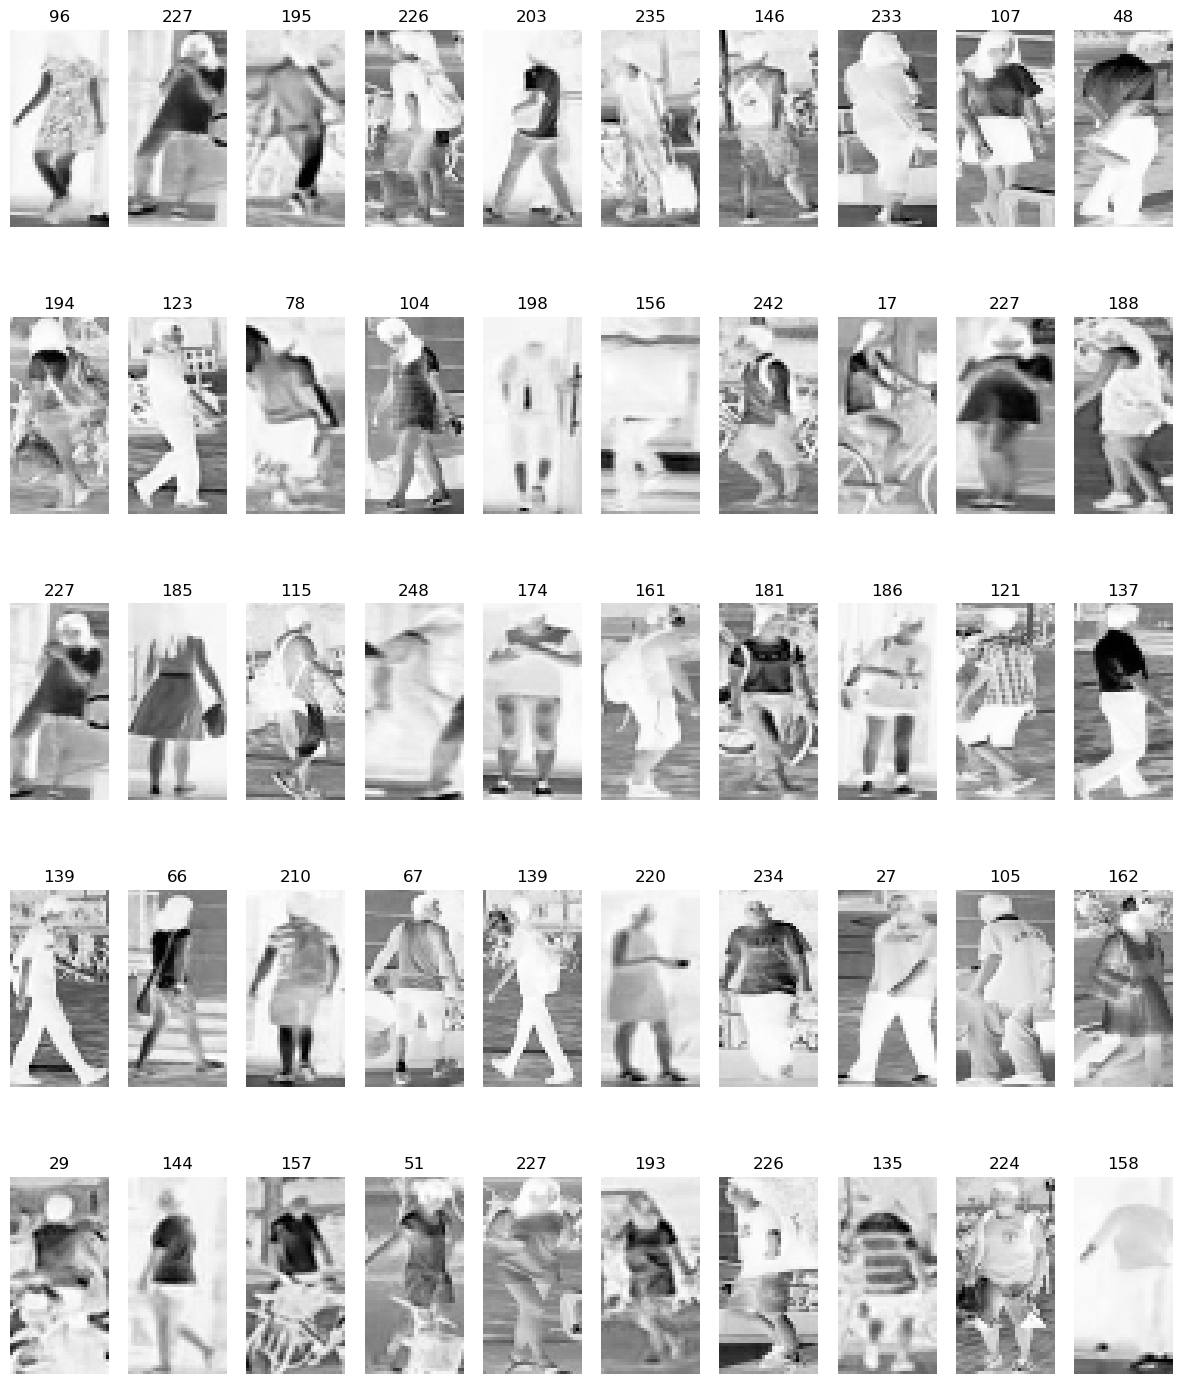

In [11]:
# Show preprocessed training images (resized and grayscale)
plot_images(train_X, train_Y)

# Save plot to file
plt.savefig("preprocessed_images.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# get validation gallery and probe sets, do this after the pre-processing to avoid double handling the data
val_gallery_X, val_gallery_Y, val_probe_X, val_probe_Y = sample_gallery_and_probe(val_X, val_Y)

# Create a vectorised version of the data
# You will need this to develop your non-deep learning method. We recommend that you do your vectorisation after you've
# done any pre-processing such that you are using the exact same data for both the non-DL and DL systems. 
#
# Note that the code below will vectorise the raw version of the data. If you have done any resizing, colour conversion, etc,
# change this to vectorise that version of the data
train_X_vec = vectorise(train_X)
val_X_vec = vectorise(val_X)
val_gallery_X_vec = vectorise(val_gallery_X)
val_probe_X_vec = vectorise(val_probe_X)
gallery_X_vec = vectorise(gallery_X)
probe_X_vec = vectorise(probe_X)

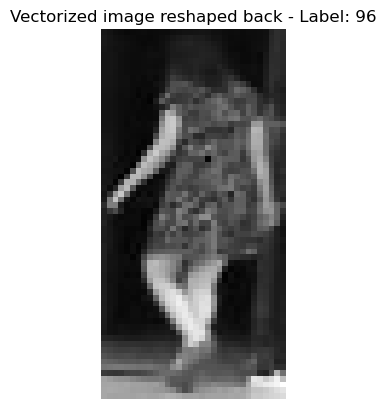

In [13]:
# Check one vectorized image and reshape back to 64x32 for visual confirmation
sample_vec = train_X_vec[0]
sample_img = sample_vec.reshape((64, 32))  # assuming grayscale (no 3 channels)

plt.imshow(sample_img, cmap='gray')
plt.title(f"Vectorized image reshaped back - Label: {train_Y[0]}")
plt.axis('off')
plt.savefig("vectorized_sample_image.png", dpi=300, bbox_inches='tight')
plt.show()

#### Shape Check

In [14]:
print("Train vectorised shape:", train_X_vec.shape)
print("Validation vectorised shape:", val_X_vec.shape)
print("Gallery vectorised shape:", gallery_X_vec.shape)
print("Probe vectorised shape:", probe_X_vec.shape)

Train vectorised shape: (4711, 2048)
Validation vectorised shape: (1222, 2048)
Gallery vectorised shape: (301, 2048)
Probe vectorised shape: (301, 2048)


### Non-DL Method

In [15]:
# Using the vectorised data, develop your non-DL method. A suggested approach would be:
# - Train a PCA, LDA, or both PDA and LDA subspace using the training data. Note that you will need to select the method(s), 
#   and choose any key parameters (for example, if you use PCA how many components you retain)
# - Using the trained subspace, project the gallery and probe data.
#
# If you wish to use the validation set:
#  - Use the val_gallery and val_probe sets to determine the transform to use / number of components to keep. You would compute
#    CMC curves / rank-1 accuracy for different options and pick the one that works best on the validation set (see below for
#    info on computing CMC curves, etc).
#

#### PCA Training and Transformation

In [16]:
from sklearn.decomposition import PCA

# Fit PCA on training data
pca = PCA(n_components=100)  # You can experiment with 100, 200, etc.
pca.fit(train_X_vec)

# Transform probe and gallery data
probe_X_pca = pca.transform(probe_X_vec)
gallery_X_pca = pca.transform(gallery_X_vec)

#### Rank Gallery Images for Each Probe Image

In [17]:
# Rank gallery samples for each probe based on L2 distance
ranked = get_ranked_histogram_l2_distance(gallery_X_pca, gallery_Y, probe_X_pca, probe_Y)

#### Compute and Plot CMC Curve

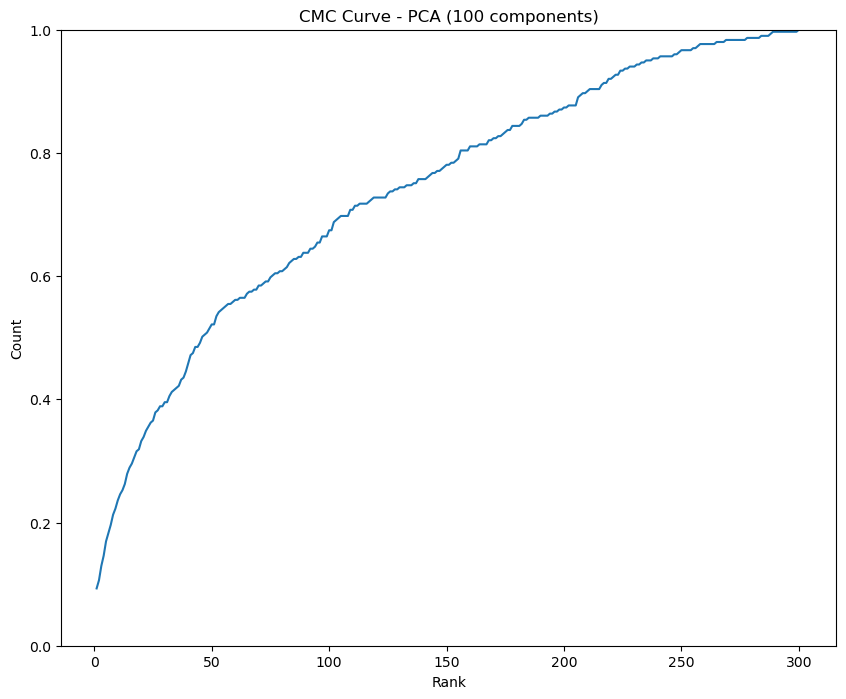

Top-1 Accuracy: 9.30%
Top-5 Accuracy: 16.94%
Top-10 Accuracy: 23.59%


In [18]:
# Compute CMC scores
cmc_scores = ranked_hist_to_CMC(ranked)

# Plot the CMC curve
import matplotlib.pyplot as plt

plot_cmc(cmc_scores)
plt.title("CMC Curve - PCA (100 components)")

# Save the figure
plt.savefig("cmc_curve_pca.png", dpi=300, bbox_inches='tight')
plt.show()

# Display Top-1, Top-5, Top-10 accuracy
print("Top-1 Accuracy: {:.2f}%".format(cmc_scores[0] * 100))
print("Top-5 Accuracy: {:.2f}%".format(cmc_scores[4] * 100))
print("Top-10 Accuracy: {:.2f}%".format(cmc_scores[9] * 100))


### Train the LDA Model

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize LDA
lda = LinearDiscriminantAnalysis()

# Fit LDA on the vectorised training data and labels
lda.fit(train_X_vec, train_Y)


LinearDiscriminantAnalysis()

#### Transform Gallery and Probe Sets

In [20]:
# Transform the vectorised gallery and probe sets
gallery_X_lda = lda.transform(gallery_X_vec)
probe_X_lda = lda.transform(probe_X_vec)

#### Rank and Evaluate Using CMC

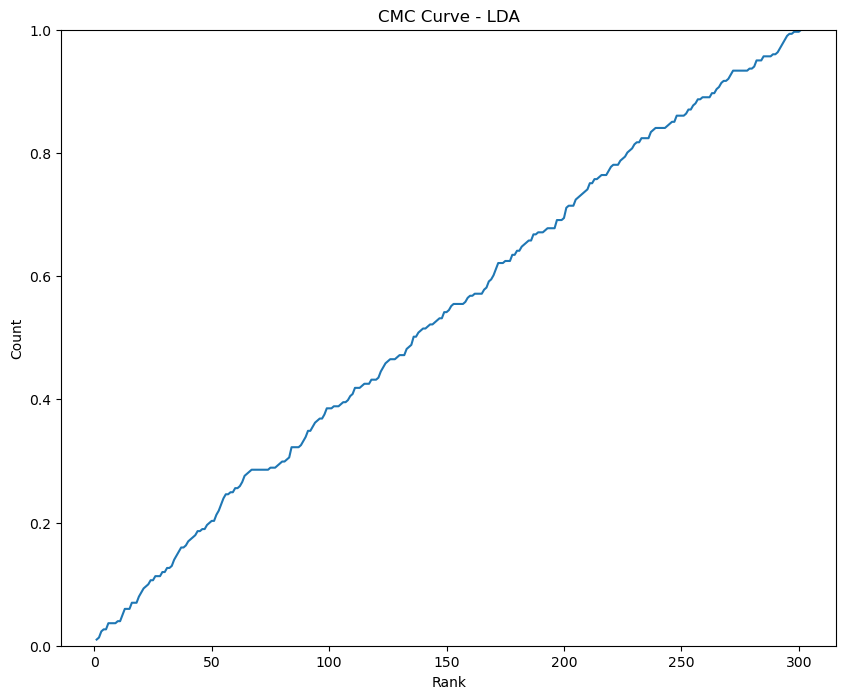

Top-1 Accuracy: 1.00%
Top-5 Accuracy: 2.66%
Top-10 Accuracy: 3.99%


In [21]:
# Match and rank using L2 distance
ranked_lda = get_ranked_histogram_l2_distance(gallery_X_lda, gallery_Y, probe_X_lda, probe_Y)

# Compute CMC scores
cmc_scores_lda = ranked_hist_to_CMC(ranked_lda)

# Plot and save the CMC curve
plot_cmc(cmc_scores_lda)
plt.title("CMC Curve - LDA")
plt.savefig("cmc_curve_lda.png", dpi=300, bbox_inches='tight')
plt.show()

# Display Top-N accuracy
print("Top-1 Accuracy: {:.2f}%".format(cmc_scores_lda[0] * 100))
print("Top-5 Accuracy: {:.2f}%".format(cmc_scores_lda[4] * 100))
print("Top-10 Accuracy: {:.2f}%".format(cmc_scores_lda[9] * 100))

### DL Method (Siamese)

In [22]:
 # Using the image data, develop your DL method. A suggested approach would be:
#  - Pick a backbone for your network. This could be a network from the lecture or prac examples, or something from
#    keras.applications. As per Assignment 1A, the network does not need to be overly complex, but you should briefly explain 
#    your selection of this model. You should avoid networks so simple that they perform very badly.
#  - Pick your training approach. You have been given pair and triplet creation functions above, so you can easily use either contrastive
#    or a triplet loss. You could also look at the bonus example on hard negative mining and consider this approach. Once you've
#    picked your approach, set the network up with the correct number of inputs and an appropriate loss.
#  - Create some pairs and triplets, and train the network using the training set
#
# If you wish to use the validation set:
#  - Use the val_X and val_Y set with your pair/triplet/whatever function to determine when your model has converged
#  - Use the val_gallery and val_probe sets to determine other network parameters such as embedding sizes. You would compute
#    CMC curves / rank-1 accuracy for different options and pick the one that works best on the validation set (see below for
#    info on computing CMC curves, etc).
#

#### Generate Training Pairs

In [23]:
# Generate pairs and labels for the Siamese network
# Generate training pairs and labels
pairs, siamese_train_Y = get_siamese_data(train_X, train_Y, 5000)

# Unpack the pairs into X1 and X2
siamese_train_X1 = pairs[0]
siamese_train_X2 = pairs[1]

##### Optional Check (Sanity)

In [24]:
import numpy as np
unique, counts = np.unique(siamese_train_Y, return_counts=True)
print("Pair label distribution:", dict(zip(unique, counts)))

Pair label distribution: {0.0: 2500, 1.0: 2500}


In [25]:
# Expand dimensions for grayscale channel
# If needed, squeeze to remove extra dimension first
siamese_train_X1 = np.squeeze(siamese_train_X1)
siamese_train_X2 = np.squeeze(siamese_train_X2)

# Now add the correct channel dimension
X1 = np.expand_dims(siamese_train_X1, axis=-1)  # should now be (5000, 64, 32, 1)
X2 = np.expand_dims(siamese_train_X2, axis=-1)

print("X1 shape:", X1.shape)
print("X2 shape:", X2.shape)

X1 shape: (5000, 64, 32, 1)
X2 shape: (5000, 64, 32, 1)


#### Build the Siamese Network

In [26]:
from tensorflow.keras import layers, Model, Input

def build_base_network(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    model = Model(inputs, x)
    return model

#### Build the Siamese Network Using the Shared Encoder

In [27]:
import tensorflow as tf

# Input shape for grayscale image: (64, 32, 1)
input_shape = (64, 32, 1)
base_network = build_base_network(input_shape)

# Define the two input branches
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Pass both inputs through the same base network
feat_a = base_network(input_a)
feat_b = base_network(input_b)

# Compute L1 (absolute) distance between the two feature vectors
l1_distance = layers.Lambda(lambda tensors: tf.math.abs(tensors[0] - tensors[1]))([feat_a, feat_b])

# Final prediction layer (sigmoid for similarity)
output = layers.Dense(1, activation='sigmoid')(l1_distance)

# Define the complete Siamese model
siamese_model = Model(inputs=[input_a, input_b], outputs=output)

# Compile the model
siamese_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
siamese_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 64, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │  1,067,520 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,067,649 (4.07 MB)

 Trainable params: 1,067,649 (4.07 MB)

 Non-trainable params: 0 (0.00 B)

#### Training Code

In [28]:
# Train the Siamese model
history = siamese_model.fit(
    [X1, X2], siamese_train_Y,
    batch_size=32,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10


I0000 00:00:1746758390.143054     137 service.cc:148] XLA service 0x7fc3b4005110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746758390.143114     137 service.cc:156]   StreamExecutor device (0): NVIDIA A16-4Q, Compute Capability 8.6
I0000 00:00:1746758390.300941     137 cuda_dnn.cc:529] Loaded cuDNN version 90300


 30/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5674 - loss: 0.6573

I0000 00:00:1746758391.701212     137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6008 - loss: 0.6393 - val_accuracy: 0.6990 - val_loss: 0.5734
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7544 - loss: 0.5165 - val_accuracy: 0.7530 - val_loss: 0.5187
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8182 - loss: 0.4250 - val_accuracy: 0.7640 - val_loss: 0.5076
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8917 - loss: 0.3076 - val_accuracy: 0.7440 - val_loss: 0.5663
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9279 - loss: 0.2217 - val_accuracy: 0.7820 - val_loss: 0.6045
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9686 - loss: 0.1234 - val_accuracy: 0.7650 - val_loss: 0.7245
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9854 - loss: 0.0684 - val_accuracy: 0.7720 - val_loss: 0.8235
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9946 - loss: 0.0381 - val_accuracy: 0.7630 - val

#### Generate Embeddings + Evaluate Performance

In [29]:
# Add channel dimension to gallery and probe images
gallery_dl = np.expand_dims(gallery_X, axis=-1)  # Shape: (301, 64, 32, 1)
probe_dl = np.expand_dims(probe_X, axis=-1)      # Shape: (301, 64, 32, 1)

# Extract Embeddings
# Use shared base network to extract feature vectors
gallery_embeddings = base_network.predict(gallery_dl)
probe_embeddings = base_network.predict(probe_dl)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


#### Rank & Plot CMC

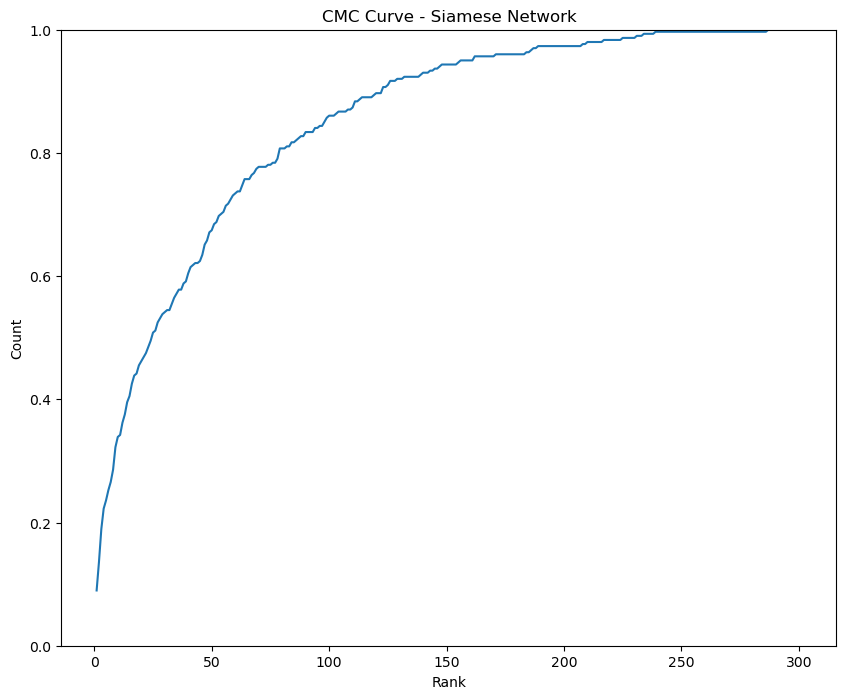

Top-1 Accuracy: 8.97%
Top-5 Accuracy: 23.59%
Top-10 Accuracy: 33.89%


In [30]:
# Perform L2 matching & ranking
ranked_dl = get_ranked_histogram_l2_distance(gallery_embeddings, gallery_Y, probe_embeddings, probe_Y)

# Compute CMC scores
cmc_scores_dl = ranked_hist_to_CMC(ranked_dl)

# Plot and save the CMC curve
plot_cmc(cmc_scores_dl)
plt.title("CMC Curve - Siamese Network")
plt.savefig("cmc_curve_dl.png", dpi=300, bbox_inches='tight')
plt.show()

# Display Top-N Accuracy
print("Top-1 Accuracy: {:.2f}%".format(cmc_scores_dl[0] * 100))
print("Top-5 Accuracy: {:.2f}%".format(cmc_scores_dl[4] * 100))
print("Top-10 Accuracy: {:.2f}%".format(cmc_scores_dl[9] * 100))

In [32]:
# For your write-up, you should include:
# - briefly mention any pre-processing you did and why; or why you left the data as-is. Note that for fair comparison, 
#   use the same pre-processing for both the methods (non-deep learning and deep-learning) is recommended. If you split 
#   the data into training and validation sets you could dicsuss this here too
# - Outline your methods. For both the non-DL and DL methods, outline what you did and why, and any key parameters you
#   set. For the DL method, outline how it was trained.
# - An evaluation, that covers the Rank-1, -5 and -10 results, and the CMC curves. Consider where performance differs
#   between the models, and the pros and cons of each.
# - A brief discsusion of the ethical considerations as they relate to person re-id (see the assignment brief for 
#   further details and references to use as a starting point
# Your write-up should be supported by appropriate figures and tables. Figures and tables should have numbers and meaningful captions.
# Note that figures and tables are not included in the page limits.
#
# SEE THE ASSIGNMENT BRIEF ON CANVAS FOR MORE DETAILS AND NOTE THAT A NOTEBOOK FILE DOES NOT CONSTITUTE A VALID SUBMISSION. 
# YOU SHOULD WRITE UP YOUR RESPONSE IN A SEPARATE DOCUMENT